# Di-Higgs momentum regressor final training

## Import

### Import modules

In [1]:
from __future__ import division, print_function
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import seaborn as sns
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore')
sys.path.append('../')
from Regression_Application import *


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
loc = '../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['260', '270', '280', '320', '300','500', '550', '600' , '700']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 9762 signal events and 168053 background events
177815 events in total


## Configure data

### Create development and validation samples

In [3]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1', 'gen_diH']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum
 

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
addHighLvl(data)
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))



In [4]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData) ))


3705 events for training, 174101 events for validation


### Apply regressors

In [5]:
hBBRegressor = HBBMassRegressor(data, "../bRegression/weights/NN_B_Regressor_SO_App_" + mode + "_", mode)
hBBRegressor.evalResponse()
hBBRegressor.getExtraVariables()

(2, 'components found in ensemble')
(2, 'components found in ensemble')


In [6]:
hTTRegressor = HTTMassRegressor(data, "../tauRegression/weights/NN_Tauh_Regressor_SO_App_" + mode + "_" ,
                                "../tauRegression/weights/NN_Taumu_Regressor_SO_App_" + mode + "_"  , mode)
hTTRegressor.evalResponse()
hTTRegressor.getExtraVariables()

(2, 'components found in ensemble')
(2, 'components found in ensemble')


### Specify variables

In [7]:

genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

In [8]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi', 't_1_mass'] if x in var]
other = [var for var in trainFeatures for x in ['prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [9]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regHBB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regHTT_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regHBB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regHTT_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in   shapeFeatures + pTEtaPhi + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]

In [10]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in hlFeatures + pTEtaPhi + regBDiHiggs] + ['hl_mT']

## Specify options

In [11]:
regTrainFeatures = set1
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_px', 'gen_diH_py', 'gen_diH_pz']
print("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])


Training on 55 features: ['t_0_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'regHBB_b_0_px', 'regHBB_b_0_py', 'regHBB_b_0_pz', 'regHBB_b_1_px', 'regHBB_b_1_py', 'regHBB_b_1_pz', 'regHBB_b_0_|p|', 'regHBB_b_0_E', 'regHBB_b_1_|p|', 'regHBB_b_1_E', 'regHBB_h_bb_px', 'regHBB_h_bb_py', 'regHBB_h_bb_pz', 'regHBB_h_bb_E', 'regHBB_h_bb_|p|', 'regHBB_h_bb_mass', 'regHTT_t_0_px', 'regHTT_t_0_py', 'regHTT_t_0_pz', 'regHTT_t_1_px', 'regHTT_t_1_py', 'regHTT_t_1_pz', 'regHTT_t_0_|p|', 'regHTT_t_0_E', 'regHTT_t_1_|p|', 'regHTT_t_1_E', 'regHTT_h_tt_px', 'regHTT_h_tt_py', 'regHTT_h_tt_pz', 'regHTT_h_tt_E', 'regHTT_h_tt_|p|', 'regHTT_h_tt_mass', 'h_tt_svFit_mass', 'diH_mass', 'diH_kinFit_mass', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'hl_mT']

Regressing to 3 features: ['gen_diH_px', 'gen_diH_py', 'gen_diH_pz']


In [12]:
devData = data.loc[sig_devIndeces].copy()
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print("{0} events for training, {1} events for validation".format(len(devData), len(valData)))

3705 events for training, 174101 events for validation


## Define regressor

In [13]:
compileArgs = {'loss' : 'mse', 'optimizer' : 'nadam'}

def getRegressor():
    regModel = Sequential()
    regModel.add(Dense(200, input_dim=len(regTrainFeatures), kernel_initializer='he_normal', activation='selu'))
    regModel.add(GaussianNoise(1))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(0.2))
    regModel.add(Dense(200, kernel_initializer='he_normal', activation='selu'))
    regModel.add(GaussianNoise(1))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(0.2))
    regModel.add(Dense(200, kernel_initializer='he_normal', activation='selu'))
    regModel.add(GaussianNoise(1))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(0.2))
    regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='he_normal'))
    regModel.compile(**compileArgs)
    return regModel

## Evaluation

### Preprocess data

In [14]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)

In [15]:
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

### Train regressors
Train nSplit times to find best convergence

In [16]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [17]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}

In [18]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
if cvTests:
    kf = KFold(n_splits=nSplits, shuffle=True)
    i = 0
    for train, test in kf.split(X_reg):
        i += 1
        print("Running fold", i, "/", nSplits)
        model = None # Clearing the NN
        model = getRegressor()
        model.reset_states #Just checking
        trainingData = (X_reg[train], y_reg[train])
        lossHistory = LossHistory()
        earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        model.fit(X_reg[train], y_reg[train],
                  validation_data = (X_reg[test], y_reg[test]),
                  callbacks = [earlyStop, saveBest, lossHistory],
                  **trainParams)
        histories.append(lossHistory.losses)
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['loss'] = model.evaluate(X_reg[test], y_reg[test], verbose=0)
        print("Score is:", results[-1])
        model.save('train_weights/train_SO' + str(i-1) + '.h5')
else :
    for i in range(nSplits):
        print("Running fold", i+1, "/", nSplits)
        model = None # Clearing the NN.
        model = getRegressor(regModel)
        model.reset_states #Just checking
        earlyStop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        histories.append(model.fit(X_reg, y_reg,
                  callbacks = [earlyStop, saveBest],
                  **trainParams))
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['loss'] = model.evaluate(X_reg, y_reg, verbose=0)
        print("Score is:", results[-1])
        model.save('train_weights/train_SO' + str(i) + '.h5')
with open('train_weights/SOresultsFile.pkl', 'wb') as fout:
    pickle.dump(results, fout)
print("Cross-validation took {:.3f}s ".format(time.time() - start))
X_reg = None
y_reg = None
train = None
test = None
model.summary()
model = None

Running fold 1 / 10
Epoch 00055: early stopping
Score is: {'loss': 0.067190461975303942}
Running fold 2 / 10
Epoch 00029: early stopping
Score is: {'loss': 0.060486230155769385}
Running fold 3 / 10
Epoch 00056: early stopping
Score is: {'loss': 0.042376028594744174}
Running fold 4 / 10
Epoch 00045: early stopping
Score is: {'loss': 0.044291325606345487}
Running fold 5 / 10
Epoch 00030: early stopping
Score is: {'loss': 0.066096733562708537}
Running fold 6 / 10
Epoch 00030: early stopping
Score is: {'loss': 0.047495437494000876}
Running fold 7 / 10
Epoch 00036: early stopping
Score is: {'loss': 0.039832579888202047}
Running fold 8 / 10
Epoch 00025: early stopping
Score is: {'loss': 0.048465474634557158}
Running fold 9 / 10
Epoch 00034: early stopping
Score is: {'loss': 0.047651100521152082}
Running fold 10 / 10
Epoch 00021: early stopping
Score is: {'loss': 0.061237137664008783}
Cross-validation took 740.551s 
_________________________________________________________________
Layer (type

### Plot training histories

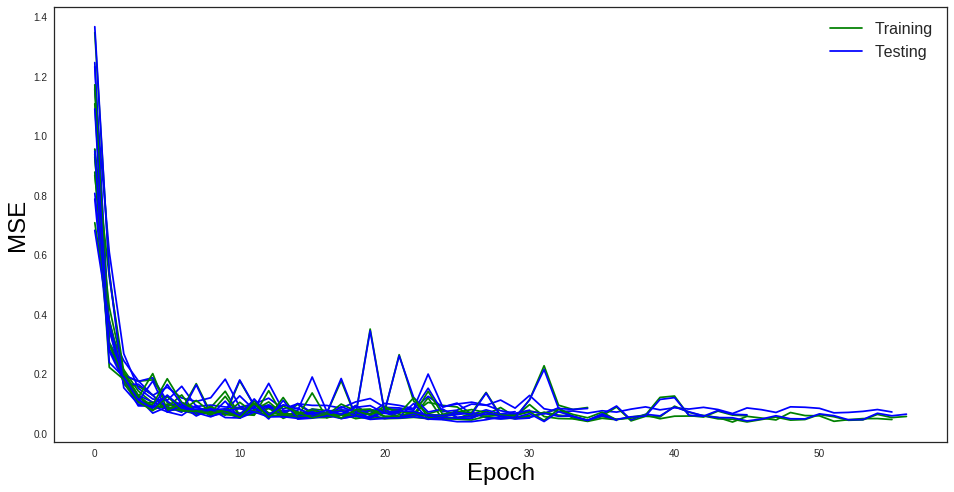

In [19]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

## Construct ensemble

In [20]:
results = None
with open('train_weights/SOresultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [21]:
def loadModel(cycle, location='train_weights/train_SO'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [22]:
def getWeights(value, met):
    return 1/value

In [23]:
ensemble = []
weights = []
print("Choosing ensemble by", ensembleMode)
if ensembleMode == 'mix':
    for met in results[0]:
        print("Choosing best for metric", met)
        cycle = np.argmin([result[met] for result in results])
        print(met, "Model", "is", cycle, "with", met, "=", results[cycle][met])
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print("Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result'])
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 6 with loss = 0.0398325798882
Model 1 is 2 with loss = 0.0423760285947
Model 2 is 3 with loss = 0.0442913256063
Model 3 is 5 with loss = 0.047495437494
Model 4 is 8 with loss = 0.0476511005212
Model 5 is 7 with loss = 0.0484654746346
Model 6 is 1 with loss = 0.0604862301558
Model 7 is 9 with loss = 0.061237137664
Model 8 is 4 with loss = 0.0660967335627
Model 9 is 0 with loss = 0.0671904619753


## Save/load

In [24]:
name = "weights/NN_HH_Mom_Regressor_App_SO" + mode + "_" 
print(name)

weights/NN_HH_Mom_Regressor_App_SOmu_tau_b_b_


### Save

In [25]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string)
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'wb') as fout:
    pickle.dump(outputPipe, fout)

## Response of ensemble on development data

###  Preprocess data

In [26]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [27]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 
for n, feature in enumerate(regTargetFeatures):
    devData['regHH_' + feature[4:]] = pandas.Series(pred[:,n], index=devData.index)

### Evaluate response

In [28]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.loc[:, 'loss_d'] += np.square(devData.loc[:, 'regHH_' + feature[4:]]-devData.loc[:, feature])
print('Ensemble on dev data:\n Loss = {}'.format(np.mean(devData.loc[:, 'loss_d'])/len(regTargetFeatures)))

Ensemble on dev data:
 Loss = 2807.29096664


## Response of ensemble on validation data

###  Preprocess data

In [29]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [30]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 
for n, feature in enumerate(regTargetFeatures):
    valData['regHH_' + feature[4:]] = pandas.Series(pred[:,n], index=valData.index)

### Evaluate response

In [31]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.loc[sig, 'loss_v'] += np.square(valData.loc[sig, 'regHH_' + feature[4:]]-valData.loc[sig, feature])
print('Ensemble on val data:\n Loss = {}'.format(np.mean(valData.loc[sig, 'loss_v'])/len(regTargetFeatures)))

Ensemble on val data:
 Loss = 3790.14814411


### Two-sample Kolmogorov–Smirnov test

In [32]:
for n, feature in enumerate(regTargetFeatures):
    print()
    print(feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['regHH_' + feature[4:]].values)
    print("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))


gen_diH_px
K-S test result 0.0367, p-value of 0.5536

gen_diH_py
K-S test result 0.0453, p-value of 0.2908

gen_diH_pz
K-S test result 0.0334, p-value of 0.6708


### Di-Higgs momenta distribution

In [33]:
pltArgs = []
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.loc[sig, feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.loc[sig, feature[4:]], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.loc[sig, 'regHH_' + feature[4:]], 'x':xPlot, 'name':'reg_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/an

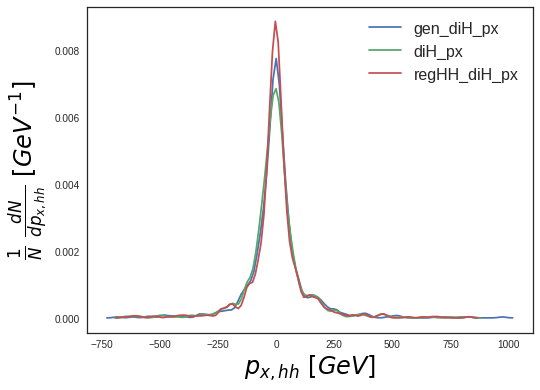

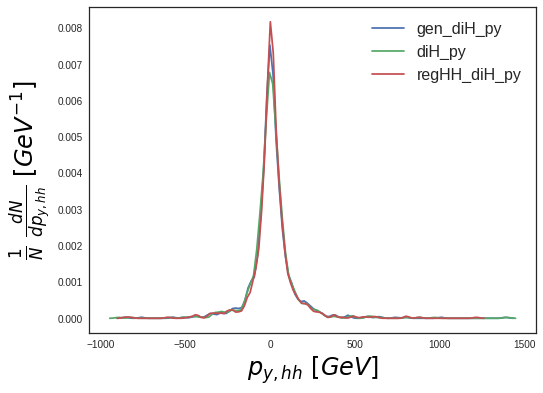

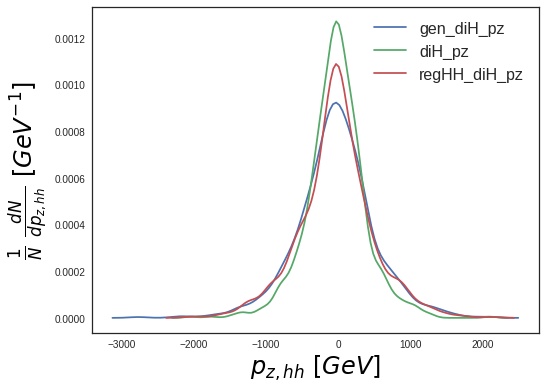

In [34]:
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    var = "p_{x,hh}"
    if "py" in feature:
        var = "p_{y,hh}"
    if "pz" in feature:
        var = "p_{z,hh}"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=valData.loc[sig, feature])
    sns.kdeplot(data=valData.loc[sig, feature[4:]])
    sns.kdeplot(data=valData.loc[sig, 'regHH_' + feature[4:]])
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Momentum pull distributions

In [35]:
pltArgs = []
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.loc[sig, feature[4:]]-valData.loc[sig, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.loc[sig, 'regHH_' + feature[4:]]-valData.loc[sig, feature], 'x':xPlot, 'name':'reg_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

Reco:	diH_px	-4.84036715843 +- 0.121713605364	34.1426470007 +- 0.198777007436
Reg:	diH_px	-1.72018452004 +- 0.119714413979	31.63283103 +- 0.210148271816
Reco:	diH_py	-0.732556708013 +- 0.0996391644787	34.4395390173 +- 0.229547693072
Reg:	diH_py	0.290249422169 +- 0.0905125189597	30.2704985332 +- 0.163561406136


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Reco:	diH_pz	5.28974538006 +- 0.586382717385	190.83244103 +- 0.998673998866
Reg:	diH_pz	3.16055574944 +- 0.301219776069	95.4492578896 +- 0.931049907179


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


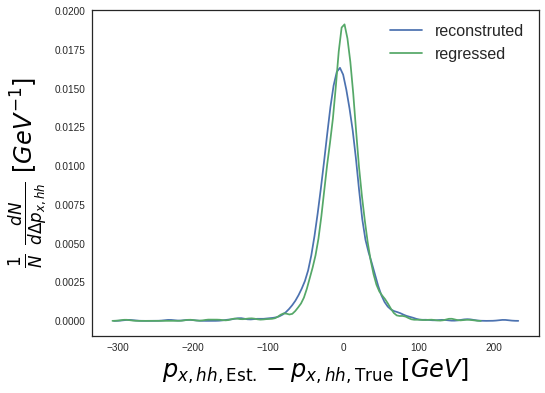

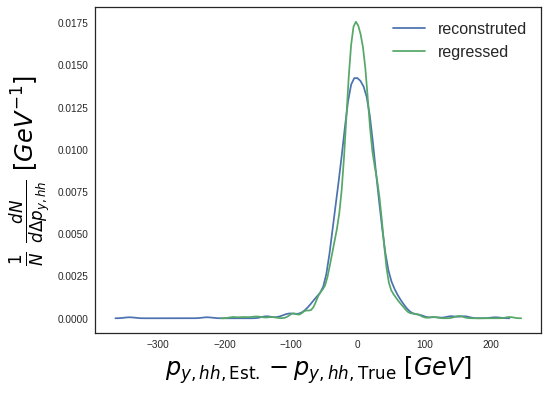

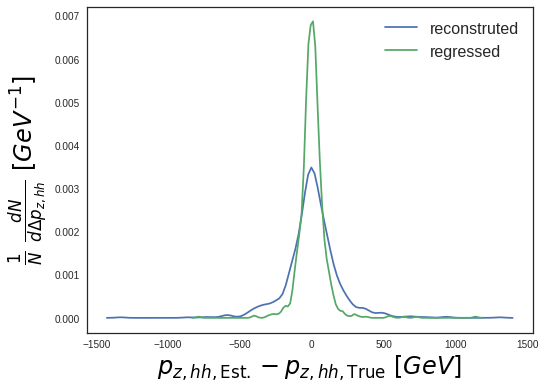

In [36]:
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,hh"
    if "py" in feature:
        var = "p_{y,hh"
    if "pz" in feature:
        var = "p_{z,hh"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print("Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=valData.loc[sig, feature[4:]]-valData.loc[sig, feature], label='reconstruted')
    mean = (np.mean(plots['reg_' + feature + '_mean']),
            np.std(plots['reg_' + feature + '_mean'])/math.sqrt(len(plots['reg_' + feature + '_mean'])))
    stdev = (np.mean(plots['reg_' + feature + '_std']),
             np.std(plots['reg_' + feature + '_std'])/math.sqrt(len(plots['reg_' + feature + '_std'])))
    print("Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=valData.loc[sig, 'regHH_' + feature[4:]]-valData.loc[sig, feature], label='regressed')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

## Save/load

In [40]:
name = "weights/NN_HH_Mom_Regressor_App_SO" + mode + "_" 
print(name)

weights/NN_HH_Mom_Regressor_App_SOmu_tau_b_b_


### Save

In [41]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string)
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'wb') as fout:
    pickle.dump(outputPipe, fout)

### Load

In [39]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'rb') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'rb') as fin:
    outputPipe = pickle.load(fin)